In [3]:
# Import dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Flatten, Dense, Input, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import splitfolders
import glob
from PIL import Image

In [4]:
splitfolders.ratio('../data/raw_images/labelled_bmp_data/', output="../data/raw_images/split_data", 
                   seed=1337, ratio=(0.7,0.2,0.1)) 

In [5]:
path_to_dataset = '../data/raw_images/split_data/'
PATH = os.path.join(os.path.dirname(path_to_dataset))
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

num_classes = 10
BATCH_SIZE = 32
IMG_SIZE = (15, 25)

In [8]:
# Train dataset 
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2168 files belonging to 10 classes.


In [9]:
# Validation dataset
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  seed=123,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 616 files belonging to 10 classes.


In [10]:
# Model - Keep it simple
model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.Conv2D(32, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
    ])

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

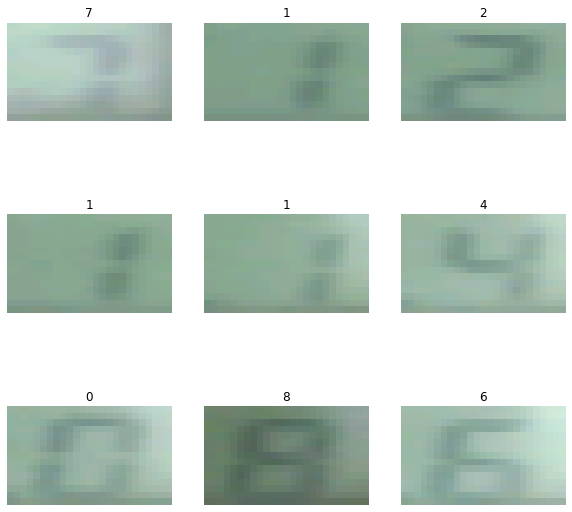

In [13]:
# Visualize the dataset 
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
def normalize_image(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [15]:
train_dataset = train_dataset.map(normalize_image)
validation_dataset = validation_dataset.map(normalize_image)

In [16]:
# Hyperparameter 
base_learning_rate = 0.001
initial_epochs = 2

# Compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate,beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 25, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 13, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 13, 16)         4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dropout (Dropout)            (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4

In [18]:
# Evaluate model before training 
loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 [==============================] - 0s 2ms/step - loss: 2.3274 - accuracy: 0.0738


In [19]:
# Train model 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/2
68/68 [==============================] - 1s 5ms/step - loss: 2.0822 - accuracy: 0.2601 - val_loss: 2.0432 - val_accuracy: 0.2992
Epoch 2/2
68/68 [==============================] - 0s 5ms/step - loss: 2.0366 - accuracy: 0.2984 - val_loss: 2.0102 - val_accuracy: 0.2910


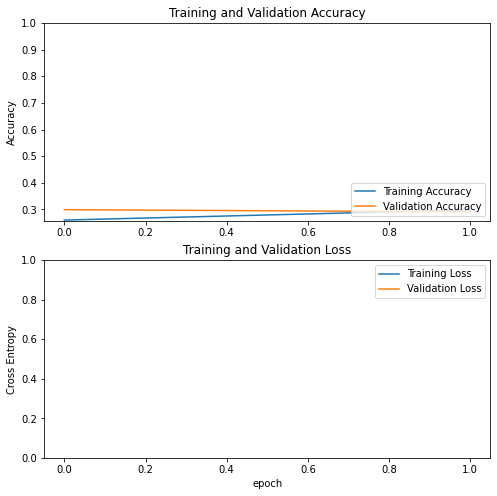

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
         return lr
    else:
        return lr * tf.math.exp(-0.1)

In [22]:
# Further finetuning
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs
scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)


history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[custom_early_stopping,scheduler_cb])

Epoch 2/102
68/68 [==============================] - 0s 5ms/step - loss: 1.9879 - accuracy: 0.3017 - val_loss: 1.9923 - val_accuracy: 0.2951
Epoch 3/102
68/68 [==============================] - 0s 5ms/step - loss: 1.9110 - accuracy: 0.3519 - val_loss: 1.8766 - val_accuracy: 0.3053
Epoch 4/102
68/68 [==============================] - 0s 5ms/step - loss: 1.8039 - accuracy: 0.4174 - val_loss: 1.6846 - val_accuracy: 0.4652
Epoch 5/102
68/68 [==============================] - 0s 5ms/step - loss: 1.5831 - accuracy: 0.5111 - val_loss: 1.3841 - val_accuracy: 0.5328
Epoch 6/102
68/68 [==============================] - 0s 5ms/step - loss: 1.2242 - accuracy: 0.6176 - val_loss: 1.0105 - val_accuracy: 0.7643
Epoch 7/102
68/68 [==============================] - 0s 5ms/step - loss: 0.8857 - accuracy: 0.7560 - val_loss: 0.6617 - val_accuracy: 0.9057
Epoch 8/102
68/68 [==============================] - 0s 5ms/step - loss: 0.6510 - accuracy: 0.8280 - val_loss: 0.4533 - val_accuracy: 0.8893
Epoch 9/102
6

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

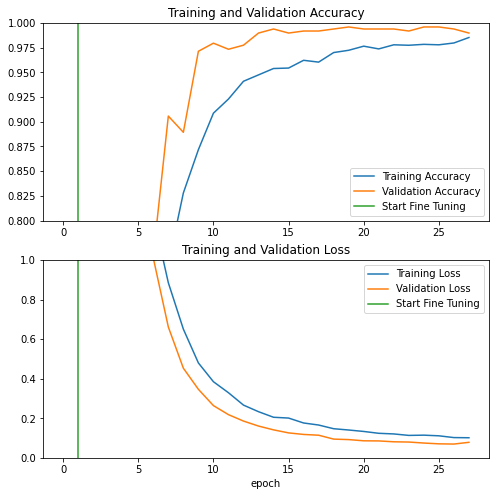

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 2ms/step - loss: 2.2744 - accuracy: 0.9688
Test accuracy : 0.96875


In [26]:
#To quantize the input and output tensors, and make the converter throw an error if it encounters an 
# operation it cannot quantize, convert the model again with some additional parameters
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, IMG_SIZE[0], IMG_SIZE[1], 3)
        yield [data.astype(np.float32)]

In [27]:
# Save model 
model.save('digit_model.h5')

In [30]:
# Load saved model 
model=tf.keras.models.load_model("digit_model.h5")

# Apply model compression -  integer-only quantization¶
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9pegbwn4/assets


INFO:tensorflow:Assets written to: /tmp/tmp9pegbwn4/assets
2022-10-10 08:31:35.154455: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-10 08:31:35.154628: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-10 08:31:35.155965: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.007ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-10 08:31:35.190897: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-10 08:31:35.190925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 9, output_inference_type: 9


In [31]:
# Save quantized model 
open("digit_model_quantized.tflite", "wb").write(tflite_quant_model)

14552

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="digit_model_quantized.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# # Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [ ]:
input_data.shape

In [ ]:
print(input_details)

In [ ]:
print(output_details)

In [ ]:
print(input_shape)

In [ ]:
print(input_data)